# Duke Silica Sphers XSVS data

In [1]:
import skxray.speckle_visibility.speckle_visibility as spe_vis
import skxray.roi as roi
import skxray.correlation as corr
import skxray.core as core

import numpy as np
import os, sys

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import LogNorm

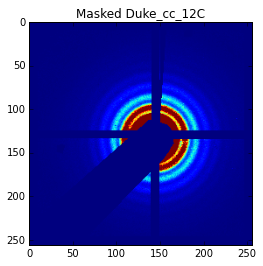

In [2]:
data_dir = "/Volumes/Data/BeamLines/CHX/Luxi_description_files_for_duke/duke_cc_12C/"
duke_ndata = np.load(data_dir+"duke_img_1_5000.npy")
duke_dark = np.load(data_dir+"duke_dark.npy")

duke_data = []
for i in range(duke_ndata.shape[0]):
    duke_data.append(duke_ndata[i] - duke_dark)
    
duke_data=np.asarray(duke_data)

#  get the avearge image of the data set
avg_img = np.average(duke_data, axis=0)
mask = ~np.load("/Volumes/Data/BeamLines/CHX/Luxi_description_files_for_duke/Luxi_duke_mask.npy")
flat_field = np.load("/Volumes/Data/BeamLines/CHX/Luxi_description_files_for_duke/Luxi_duke_flat.npy")

plt.imshow(mask*avg_img, vmax=1e0)
plt.title("Masked Duke_cc_12C")
plt.show()

## Create roi mask

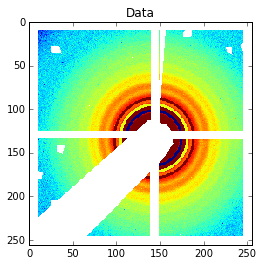

In [3]:
import skxray.roi as roi

inner_radius = 30
width = 3
spacing = 4
num_rings = 3

edges = roi.ring_edges(inner_radius, width, spacing, num_rings)

rings = roi.rings(edges, (133, 143), avg_img.shape)

def test_demo(ax, label_array, img_dim, image):
    """
    This will plot the reqiured roi's on the image
    """

    vmin, vmax = np.percentile(image, [100, 100])
    #im = ax.imshow(tt.reshape(*img_dim), cmap='Paired', interpolation='nearest')
    im = ax.imshow(image, interpolation='none', norm=LogNorm(), vmax=1e0)
    im = ax.imshow(label_array, interpolation='none', norm=LogNorm())
    #im = ax.imshow(image, interpolation='none',  vmax=1e0)
    
    
fig, ax = plt.subplots()
plt.title("Data")
test_demo(ax, rings*mask, avg_img.shape, avg_img*mask)
plt.show()

##  Get the intensities of roi's of the average image

In [4]:
roi_pix_val = spe_vis.roi_pixel_values(avg_img*mask, rings*mask)

In [5]:
edges

array([[ 30.,  33.],
       [ 37.,  40.],
       [ 44.,  47.]])

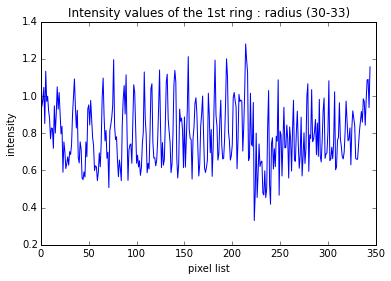

In [6]:
plt.plot(roi_pix_val.values()[0])
plt.title("Intensity values of the 1st ring : radius (30-33)")
plt.xlabel("pixel list")
plt.ylabel("intensity")
plt.show()

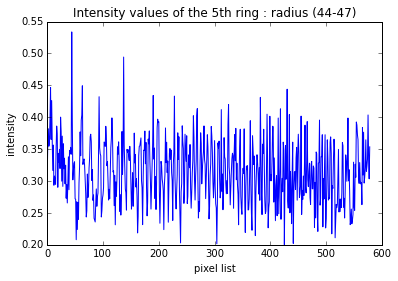

In [7]:
plt.plot(roi_pix_val.values()[2])
plt.title("Intensity values of the 5th ring : radius (44-47)")
plt.xlabel("pixel list")
plt.ylabel("intensity")
plt.show()

##  Get the Mean intensities of ROI's (Ring Averaged intensities) 

In [8]:
mask_data1 = mask*duke_data[0:2000]
mask_data2 = mask*duke_data[2001: 3000]
mask_data3 = mask*duke_data[3001: 5000]

In [11]:
yu= (mask_data1, mask_data2, mask_data3)
yu.shape

AttributeError: 'tuple' object has no attribute 'shape'

In [43]:
mean_int = spe_vis.mean_intensity(mask_data1, rings*mask)

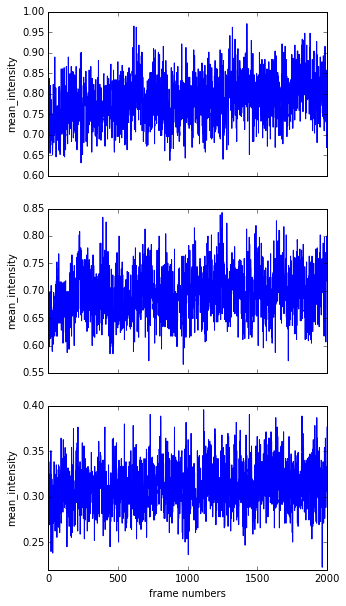

In [46]:
fig, axes = plt.subplots(num_rings, sharex=True, figsize=(5,10))
axes[num_rings-1].set_xlabel("frame numbers")
for i in zip(range(num_rings)):
    axes[i].set_ylabel("mean_intensity") 
    axes[i].plot(mean_int[:, i])
plt.show()


In [12]:
mean_int_sets = spe_vis.mean_intensity_sets(np.array((mask_data1, mask_data2, mask_data3)), rings*mask)

In [13]:
mean_int_sets

{1: array([[ 0.79710145,  0.67311828,  0.3298791 ],
        [ 0.69855072,  0.72043011,  0.33333333],
        [ 0.68695652,  0.67741935,  0.33851468],
        ..., 
        [ 0.79710145,  0.75268817,  0.32297064],
        [ 0.83478261,  0.73333333,  0.30569948],
        [ 0.69275362,  0.78494624,  0.37651123]]),
 2: array([[ 0.84347826,  0.67956989,  0.30915371],
        [ 0.7826087 ,  0.70322581,  0.33851468],
        [ 0.77391304,  0.76774194,  0.34542314],
        ..., 
        [ 0.75942029,  0.61505376,  0.3074266 ],
        [ 0.73333333,  0.74623656,  0.33160622],
        [ 0.82608696,  0.76344086,  0.33506045]]),
 3: array([[ 0.74782609,  0.6516129 ,  0.32297064],
        [ 0.7826087 ,  0.80860215,  0.32642487],
        [ 0.85217391,  0.78709677,  0.3298791 ],
        ..., 
        [ 0.79710145,  0.66666667,  0.29188256],
        [ 0.86956522,  0.69677419,  0.30397237],
        [ 0.75072464,  0.67956989,  0.34887737]])}

In [49]:
combine_int = spe_vis.combine_mean_intensity(mean_int_sets)

In [50]:
combine_int.shape

(4998, 3)

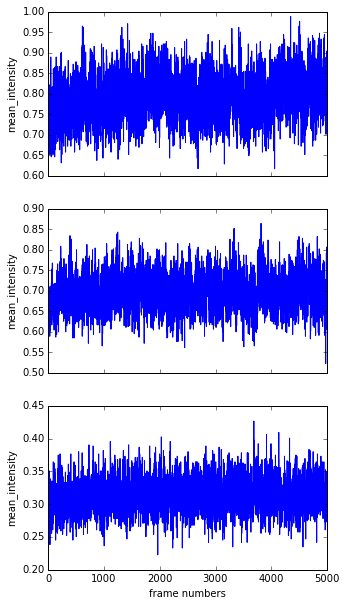

In [51]:
fig, axes = plt.subplots(num_rings, sharex=True, figsize=(5,10))
axes[num_rings-1].set_xlabel("frame numbers")
for i in zip(range(num_rings)):
    axes[i].set_ylabel("mean_intensity") 
    axes[i].plot(combine_int[:, i])
plt.show()


## Get the circular average(radial integartion) 

In [60]:
calibrated_center = (133, 143)
bin_cen, ring_avg = spe_vis.circular_average(avg_img*mask, calibrated_center, threshold=0, nx =100, pixel_size=(0.1, 0.1) )

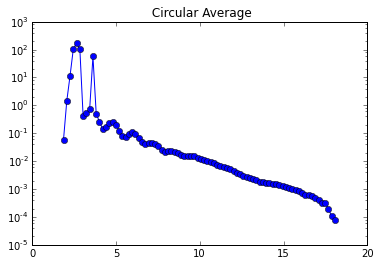

In [61]:
plt.title(" Circular Average")
plt.semilogy(bin_cen, ring_avg, '-o')
plt.show()

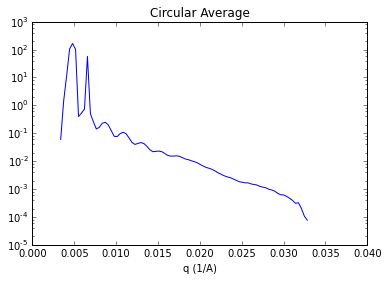

In [62]:
dist_sample = 2230 # mm

two_theta = core.radius_to_twotheta(dist_sample, bin_cen)
wavelength = 1.5498

q_val = core.twotheta_to_q(two_theta, wavelength)
plt.title("Circular Average")
plt.xlabel("q (1/A)")
plt.semilogy(q_val, ring_avg)

plt.show()